In [9]:
from Get_mask import *
from Get_Image import *


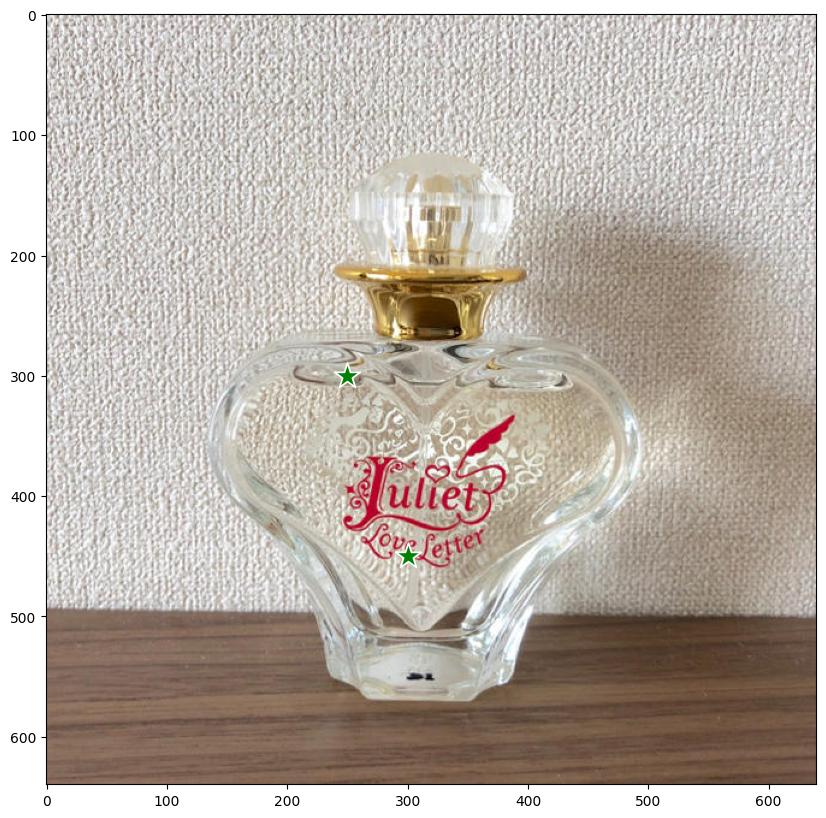

In [10]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
image_path = "/intern1/mmai06/Image_source/perfume_bottle.jpg"
mask = Get_mask(device, image_path)

input_points = [[[250, 300],[300,450]]]
mask.show_points_on_image(input_points)

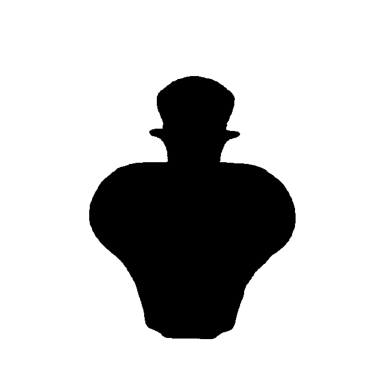

In [11]:
mask.get_mask(input_points)
masked_image = mask.get_masked_image()

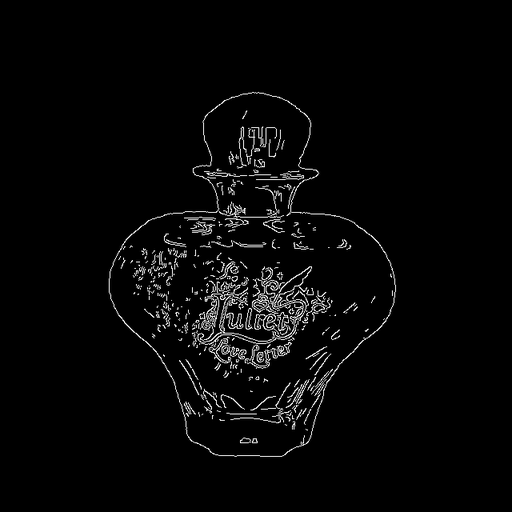

In [12]:
get_image = Get_Image(image_path)
bg_image_path = '/intern1/mmai06/SAM/bg_image.png'
bg_mask_image, bg_mask_image_np = get_image.get_bg_source(bg_image_path)

low_threshold = 250
high_threshold = 350
canny_image = get_image.object_canny(low_threshold, high_threshold, masked_image)
canny_image

In [13]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 ).to('cuda:5')

vae/diffusion_pytorch_model.safetensors not found
Loading pipeline components...:  14%|█▍        | 1/7 [00:00<00:00,  7.76it/s]An error occurred while trying to fetch /intern1/mmai06/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /intern1/mmai06/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  29%|██▊       | 2/7 [00:02<00:08,  1.73s/it]An error occurred while trying to fetch /intern1/mmai06/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /intern1/mmai06/.cache/huggingface/hub/models--runwa

 42%|████▏     | 21/50 [00:02<00:03,  9.02it/s]

100%|██████████| 50/50 [00:05<00:00,  8.91it/s]


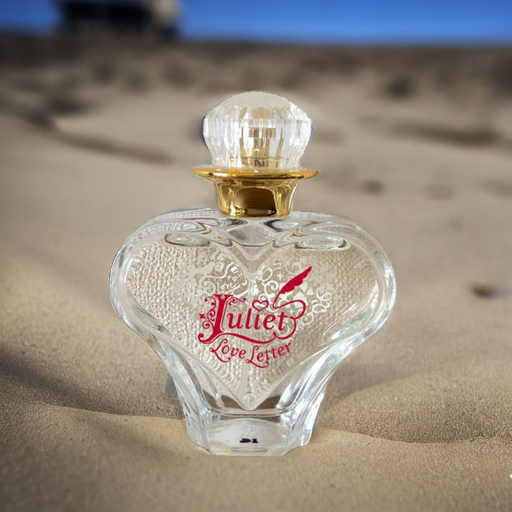

In [14]:
generator = torch.Generator().manual_seed(23)

prompt = (
"A perfume bottle is floating on the sand on a sunny day." 
)


output = pipe(
        prompt = prompt,
        num_inference_steps = 50,
        image = get_image.raw_image,
        control_image = canny_image,
        mask_image = bg_mask_image,
        controlnet_conditioning_scale =1.0,
        guidance_scale=10
    )

out = output.images[0]  # 이미지 리스트
out_image = get_image.generate_image(bg_mask_image_np, out)
out_image
